This notebook reads in the saved tile names and classification, trains the CNN, and runs standard metrics and analyses.

In [1]:
import time
import csv
import numpy as np
from tqdm import tqdm
from PIL import Image

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.utils import np_utils
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
%matplotlib inline

In [3]:
# set path parameters
tile_path = # path to the training CSVs
checkpoint_path = # save path for checkpoints

# set the split for train/test
test_fraction = 0.2

# set the number of classes to classify
n_classes = 4

# set the confidence threshold for the network
threshold = 0.85

In [4]:
# load the raw csv datasets
with open(tile_path + 'tiles.csv', newline='') as f:
    reader = csv.reader(f)
    tile_list = np.array(list(reader))

with open(tile_path + 'classes.csv', newline='') as f:
    reader = csv.reader(f)
    labels = np.array(list(reader))

In [5]:
# list to save arrays
tile_vector = []

# loop through the tiles and convert to vectors
for index in tqdm(range(0, len(tile_list))):
    
    tile = tile_list[index]
    
    # open the tile, convert to an array
    image = Image.open(tile[0])
    array = np.asarray(image)
    
    # scale each array to be between 0 and 1
    array = array/255
    
    # reshape it
    array = np.expand_dims(array, axis=2)
    
    # save to the list
    tile_vector.append(array)

# convert the list to an array
tile_vector = np.array(tile_vector)

100%|███████████████████████████████████████████████████████████████████████████| 18154/18154 [00:55<00:00, 325.56it/s]


In [6]:
# split the data into train and test
feature_train, feature_test, label_train, label_test = train_test_split(tile_vector, 
                                                                        labels, 
                                                                        test_size=test_fraction, 
                                                                        random_state=6, 
                                                                        shuffle=True)

In [7]:
print('Shape before one-hot encoding:', label_train.shape)

# use one-hot encoding via keras 
label_train = np_utils.to_categorical(label_train, n_classes)
label_test = np_utils.to_categorical(label_test, n_classes)

print('Shape after one-hot encoding:', label_train.shape)

Shape before one-hot encoding: (14523, 1)
Shape after one-hot encoding: (14523, 4)


In [8]:
# set up augmentation to randomly flip tiles
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

# create the iterator
augmented_train = datagen.flow(feature_train, label_train)

In [9]:
# build a sequential CNN
model = Sequential()
model.add(InputLayer(input_shape=(array.shape[0], array.shape[0], 1)))

# 1st conv block
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# 2nd conv block
model.add(Conv2D(64, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd conv block
model.add(Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())

# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))

# set a dropout to avoid overfitting, the fraction represents values reset after every epoch
model.add(Dropout(0.4))

# output layer
model.add(Dense(units=n_classes, activation='softmax'))

# print the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0

In [10]:
# set the optimizer function
opt = Adam(learning_rate=0.00001)

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [18]:
# set the model to save the best results as determined from the validation accuracy
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [21]:
# training the model for 50 epochs
history = model.fit(augmented_train,
                    shuffle=True, 
                    epochs=50, 
                    validation_data=(feature_test, label_test),
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
454/454 [==============================] - 160s 353ms/step - loss: 0.4835 - accuracy: 0.8140 - val_loss: 0.4977 - val_accuracy: 0.8069
Epoch 2/50
454/454 [==============================] - 161s 354ms/step - loss: 0.4743 - accuracy: 0.8199 - val_loss: 0.4984 - val_accuracy: 0.8012
Epoch 3/50
454/454 [==============================] - 161s 354ms/step - loss: 0.4705 - accuracy: 0.8186 - val_loss: 0.4909 - val_accuracy: 0.8102
Epoch 4/50
454/454 [==============================] - 161s 354ms/step - loss: 0.4681 - accuracy: 0.8201 - val_loss: 0.4935 - val_accuracy: 0.8130
INFO:tensorflow:Assets written to: E:/USGS/checkpoints\assets
Epoch 5/50
454/454 [==============================] - 158s 348ms/step - loss: 0.4643 - accuracy: 0.8206 - val_loss: 0.4910 - val_accuracy: 0.8075
Epoch 6/50
454/454 [==============================] - 159s 349ms/step - loss: 0.4566 - accuracy: 0.8235 - val_loss: 0.4864 - val_accuracy: 0.8169
INFO:tensorflow:Assets written to: E:/USGS/checkpoints\assets


In [ ]:
# plot the training progress from the history object
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

# set labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# set other parameters
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

plt.show();

In [ ]:
# plot the training progress from the history object
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

# set labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# set other parameters
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.show();

In [12]:
# load best model
model = load_model(r"E:\USGS\checkpoints\final")

In [14]:
# set the start time
start_time = time.time()

# generate predictions
predictions = model.predict(feature_test)

# get the end time
end_time = time.time()

# print results
print('Model predicts at {} tiles/second.'.format(round(len(predictions)/(end_time-start_time))))

Model predicts at 240 tiles/second.


In [15]:
# convert predictions and truth values to lists
test_prediction_list = []
label_test_list = []

# add to list
for result in predictions:
    test_prediction_list.append(np.where(result == np.max(result))[0][0])

# add to list
for label in label_test:
    label_test_list.append(np.where(label == np.max(label))[0][0])

## Overall metrics

In [13]:
# generate the standard classification report
class_report_all = classification_report(label_test_list, test_prediction_list, zero_division=1)
print(class_report_all)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1309
           1       0.85      0.82      0.83      1666
           2       0.72      0.76      0.74       618
           3       1.00      0.00      0.00        38

    accuracy                           0.82      3631
   macro avg       0.85      0.61      0.61      3631
weighted avg       0.82      0.82      0.82      3631



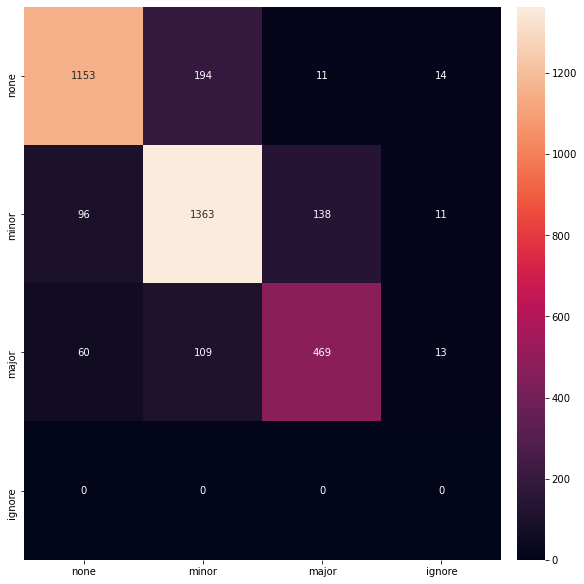

In [19]:
# generate confusion matrix
cm = confusion_matrix(test_prediction_list, label_test_list)

# set basic figure parameters
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), constrained_layout=True)

# change the labels
x_axis_labels = ['none', 'minor', 'major', 'ignore']
y_axis_labels = ['none', 'minor', 'major', 'ignore']

# plot the heatmaps
sn.heatmap(cm, annot=True, ax=axes, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g')

plt.show()

## With confidence threshold

In [16]:
# set up counters
correct = 0
total = 0

# set up empty label lists
threshold_predict = []
threshold_true = []

for index in range(len(test_prediction_list)):
    
    # check if the model's confidence is higher than the threshold
    if np.max(predictions[index]) > threshold:                
        
        # add the labels to the thresholded lists
        threshold_predict.append(test_prediction_list[index])
        threshold_true.append(label_test_list[index])
        
        # check for incorrect guesses
        if test_prediction_list[index] != label_test_list[index]:
            
            # count the guess as valid but wrong
            total += 1
        
        # otherwise count it as correct as valid
        else:   
            total += 1
            correct +=1

print('With a threshold of {}, model is {}% accurate.\n'.format(threshold, 
                                                               round(100*correct/total)))
print('{}% of the tiles exceeded the threshold.'.format(round(100*total/len(predictions))))

With a threshold of 0.85, model is 92% accurate.

66% of the tiles exceeded the threshold.


In [18]:
# generate the thresholded classification report
class_report_thresholded = classification_report(threshold_true, threshold_predict, zero_division=1)
print(class_report_thresholded)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1013
           1       0.92      0.93      0.92      1030
           2       0.87      0.82      0.84       321
           3       1.00      0.00      0.00        16

    accuracy                           0.92      2380
   macro avg       0.93      0.68      0.68      2380
weighted avg       0.92      0.92      0.91      2380



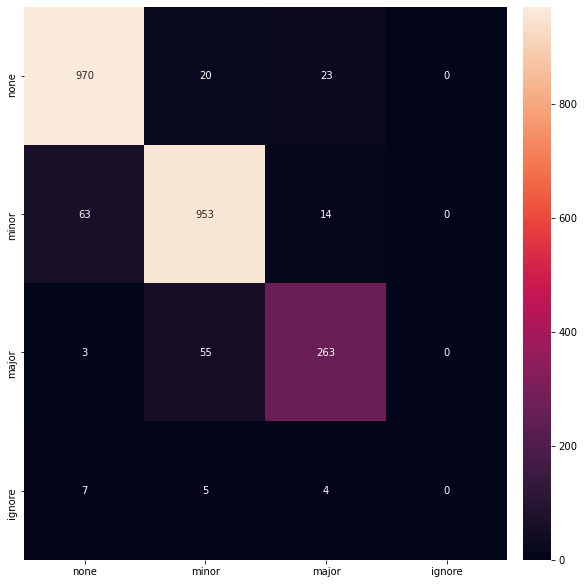

In [22]:
# generate confusion matrix for the thresholded values
cm = confusion_matrix(threshold_true, threshold_predict)

# set basic figure parameters
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), constrained_layout=True)

# change the labels
x_axis_labels = ['none', 'minor', 'major', 'ignore']
y_axis_labels = ['none', 'minor', 'major', 'ignore']

# plot the heatmaps
sn.heatmap(cm, annot=True, ax=axes, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g')

plt.show()